In [1]:
%run ../notebooks/00_setup_paths.ipynb

utils/ folder added to Python import path
project_root:     C:\Users\akaas\crime-projectMain
raw_dir:          C:\Users\akaas\crime-projectMain\data
parquet_dir:      C:\Users\akaas\crime-projectMain\data_parquet
processed_dir:    C:\Users\akaas\crime-projectMain\data_processed
models_dir:       C:\Users\akaas\crime-projectMain\models
logs_dir:         C:\Users\akaas\crime-projectMain\logs
utils_dir:        C:\Users\akaas\crime-projectMain\utils


In [2]:
from spark_init import init_spark
spark = init_spark("CrimeProject_Phase4", driver_memory="12g")
spark

Spark Initialized: CrimeProject_Phase4


In [3]:
from pyspark.sql import functions as F
from pyspark.sql import Window
from pathlib import Path

In [4]:
master_dir = processed_dir / "incidents_master"
incident_master = spark.read.parquet(str(master_dir))
incident_master.printSchema()

root
 |-- unique_incident_id: string (nullable = true)
 |-- city_submissions: string (nullable = true)
 |-- cleared_exceptionally: string (nullable = true)
 |-- exceptional_clearance_date: string (nullable = true)
 |-- incident_date: string (nullable = true)
 |-- incident_date_hour: string (nullable = true)
 |-- incident_number: string (nullable = true)
 |-- ori: string (nullable = true)
 |-- report_date_indicator: string (nullable = true)
 |-- state: string (nullable = true)
 |-- state_abb: string (nullable = true)
 |-- total_arrestee_segments: string (nullable = true)
 |-- total_offender_segments: string (nullable = true)
 |-- total_offense_segments: string (nullable = true)
 |-- total_victim_segments: string (nullable = true)
 |-- year: string (nullable = true)
 |-- offense_codes: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- num_offenses: long (nullable = true)
 |-- num_victims: long (nullable = true)
 |-- num_offenders: long (nullable = true)
 |-- to

In [5]:
df = (
    incident_master
    .withColumn("incident_date_clean",
                F.to_date("incident_date", "yyyy-MM-dd"))
    .withColumn("year_filled", 
                F.when(F.col("incident_date_clean").isNull(),
                       F.col("year").cast("int"))
                 .otherwise(F.year("incident_date_clean")))
)


In [6]:
df = (
    df
    .withColumn("year", F.col("year_filled"))
    .withColumn("month", F.month("incident_date_clean"))
    .withColumn("weekofyear", F.weekofyear("incident_date_clean"))
)


In [7]:
monthly = (
    df.groupBy("ori", "state", "year", "month")
      .agg(
          F.count("*").alias("total_crimes"),
          F.sum("num_victims").alias("total_victims"),
          F.sum("total_property_value").alias("total_property_loss")
      )
      .orderBy("ori", "year", "month")
)

monthly.show(20)


+---------+------+----+-----+------------+-------------+-------------------+
|      ori| state|year|month|total_crimes|total_victims|total_property_loss|
+---------+------+----+-----+------------+-------------+-------------------+
|AK0010200|alaska|2021|    1|         215|          244|           492001.0|
|AK0010200|alaska|2021|    2|         174|          184|           309540.0|
|AK0010200|alaska|2021|    3|         203|          229|           397318.0|
|AK0010200|alaska|2021|    4|         178|          197|           433205.0|
|AK0010200|alaska|2021|    5|         213|          235|           579866.0|
|AK0010200|alaska|2021|    6|         249|          280|           651539.0|
|AK0010200|alaska|2021|    7|         257|          281|           640429.0|
|AK0010200|alaska|2021|    8|         235|          256|           373071.0|
|AK0010200|alaska|2021|    9|         236|          254|           307537.0|
|AK0010200|alaska|2021|   10|         220|          242|           592019.0|

In [8]:
window_3 = Window.partitionBy("ori").orderBy("year", "month").rowsBetween(-2, 0)
window_6 = Window.partitionBy("ori").orderBy("year", "month").rowsBetween(-5, 0)
window_12 = Window.partitionBy("ori").orderBy("year", "month").rowsBetween(-11, 0)

monthly_fe = (
    monthly
    .withColumn("roll3", F.avg("total_crimes").over(window_3))
    .withColumn("roll6", F.avg("total_crimes").over(window_6))
    .withColumn("roll12", F.avg("total_crimes").over(window_12))
    .withColumn("lag1", F.lag("total_crimes", 1).over(Window.partitionBy("ori").orderBy("year", "month")))
    .withColumn("lag2", F.lag("total_crimes", 2).over(Window.partitionBy("ori").orderBy("year", "month")))
)


In [9]:
monthly_fe = (
    monthly_fe
    .withColumn("month_sin", F.sin(2 * 3.1416 * F.col("month") / 12))
    .withColumn("month_cos", F.cos(2 * 3.1416 * F.col("month") / 12))
)

In [10]:
phase4_dir = processed_dir / "phase4_timeseries"
phase4_dir.mkdir(exist_ok=True)

monthly_fe.write.mode("overwrite").parquet(str(phase4_dir))

print("Phase 4 time-series dataset saved:", phase4_dir)

Phase 4 time-series dataset saved: C:\Users\akaas\crime-projectMain\data_processed\phase4_timeseries


In [11]:
monthly_path = processed_dir / "phase4_timeseries"
df = spark.read.parquet(str(monthly_path))

df_spark = df.toPandas()
df_spark.columns
df_spark.head()

,ori,state,year,month,total_crimes,total_victims,total_property_loss,roll3,roll6,roll12,lag1,lag2,month_sin,month_cos
0,AK0010900,alaska,2019,4,1,1,NaN,1.000000,1.00,1.00,NaN,NaN,0.866023,-0.500004
1,AK0010900,alaska,2020,8,1,1,1330.0,1.000000,1.00,1.00,1.0,NaN,-0.866030,-0.499992
2,AK0010900,alaska,2020,12,1,1,1115.0,1.000000,1.00,1.00,1.0,1.0,0.000015,1.000000
3,AK0010900,alaska,2021,1,8,8,13025.0,3.333333,2.75,2.75,1.0,1.0,0.500001,0.866025
4,AK0010900,alaska,2021,2,5,5,2365.0,4.666667,3.20,3.20,8.0,1.0,0.866027,0.499998


In [12]:
ml_df = df_spark[[    
    "ori",
    "state",
    "year",
    "month",
    "total_crimes",
    "total_victims",
    "total_property_loss",
    "lag1", "lag2",            
    "roll3", "roll6", "roll12",
    "month_sin", "month_cos"
]]


In [13]:
import pandas as pd

# ensure sorted & reset index
ml_df = ml_df.sort_values(["ori", "year", "month"]).reset_index(drop=True)

datasets = {}

for ori in ml_df["ori"].unique():
    city_df = ml_df[ml_df["ori"] == ori].sort_values(["year", "month"])

    # require minimum data
    if len(city_df) < 15:
        continue

    # split point
    train_df = city_df.iloc[:-3].copy()
    test_df  = city_df.iloc[-3:].copy()

    # add into dictionary as Pandas DataFrames
    datasets[ori] = {
        "train": train_df.reset_index(drop=True),
        "test":  test_df.reset_index(drop=True)
    }

len(datasets), "cities processed"


(13668, 'cities processed')

In [14]:
feature_cols = [
    "total_crimes",
    "roll3", "roll6", "roll12",
    "lag1", "lag2",
    "month_sin", "month_cos",
    "year"
]

target_col = "total_crimes"

In [15]:
import random
random.seed(42)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

results = []
metrics = []

loop_counter = 0

for ori, parts in datasets.items():
    loop_counter += 1
    if loop_counter % 3000 == 0:
        print(f"Loop iterations so far: {loop_counter}")

    train = parts["train"]
    test  = parts["test"]

    if len(train) < 10:
        continue

    X_train = train[feature_cols].fillna(0)
    y_train = train[target_col]

    X_test  = test[feature_cols].fillna(0)
    y_test  = test[target_col]

    model = RandomForestRegressor(
        n_estimators=200,
        random_state=42
    )
    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    metrics.append({
        "ori": ori,
        "mae": mae,
        "rmse": rmse
    })

    for i in range(len(test)):

        loop_counter += 1
        if loop_counter % 3000 == 0:
            print(f"Loop iterations so far: {loop_counter}")
            
        results.append({
            "ori": ori,
            "year": int(test.iloc[i]["year"]),
            "month": int(test.iloc[i]["month"]),
            "actual": float(y_test.iloc[i]),
            "predicted": float(preds[i])
        })


Loop iterations so far: 3000
Loop iterations so far: 6000
Loop iterations so far: 9000
Loop iterations so far: 12000
Loop iterations so far: 15000
Loop iterations so far: 18000
Loop iterations so far: 21000
Loop iterations so far: 24000
Loop iterations so far: 27000
Loop iterations so far: 30000
Loop iterations so far: 33000
Loop iterations so far: 36000
Loop iterations so far: 39000
Loop iterations so far: 42000
Loop iterations so far: 45000
Loop iterations so far: 48000
Loop iterations so far: 51000
Loop iterations so far: 54000


In [16]:
import pandas as pd

results_df = pd.DataFrame(results)
metrics_df = pd.DataFrame(metrics)

results_df.head(), metrics_df.head()


(         ori  year  month  actual  predicted
 0  AK0010200  2024     10   165.0    169.265
 1  AK0010200  2024     11   172.0    169.635
 2  AK0010200  2024     12   173.0    169.185
 3  AK0010300  2024     10    91.0    109.020
 4  AK0010300  2024     11    97.0    109.915,
          ori        mae       rmse
 0  AK0010200   3.481667   3.574804
 1  AK0010300  13.838333  14.182783
 2  AK0010400   0.483333   0.626724
 3  AK0010500   1.671667   2.554521
 4  AK0010600   0.830000   0.874366)

In [17]:
out_dir = processed_dir / "phase4_results"
out_dir.mkdir(exist_ok=True)

results_df.to_csv(out_dir / "predictions.csv", index=False)
metrics_df.to_csv(out_dir / "metrics.csv", index=False)

print("Saved phase 4 results to:", out_dir)

Saved phase 4 results to: C:\Users\akaas\crime-projectMain\data_processed\phase4_results


In [21]:
hotspot_threshold = ml_df["total_crimes"].quantile(0.90)

ml_df["hotspot"] = (
    ml_df["total_crimes"] >= hotspot_threshold
).astype(int)

ml_df["hotspot"].value_counts(normalize=True)

hotspot
0    0.899438
1    0.100562
Name: proportion, dtype: float64

In [24]:

feature_cols = [
    "lag1", "lag2",
    "roll3", "roll6", "roll12",
    "month_sin", "month_cos",
    "total_property_loss"
]

X = ml_df[feature_cols].fillna(0)
y = ml_df["hotspot"]

In [25]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=False
)

In [ ]:
from sklearn.linear_model import LogisticRegression

hotspot_model = LogisticRegression(max_iter=2000)
hotspot_model.fit(X_train, y_train)

In [26]:
from sklearn.linear_model import LogisticRegression

hotspot_model = LogisticRegression(max_iter=2000)
hotspot_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [27]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

y_prob = hotspot_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

ROC-AUC: 0.9970946993156165

Confusion Matrix:
 [[     1 248964]
 [     0  29618]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00    248965
           1       0.11      1.00      0.19     29618

    accuracy                           0.11    278583
   macro avg       0.55      0.50      0.10    278583
weighted avg       0.90      0.11      0.02    278583



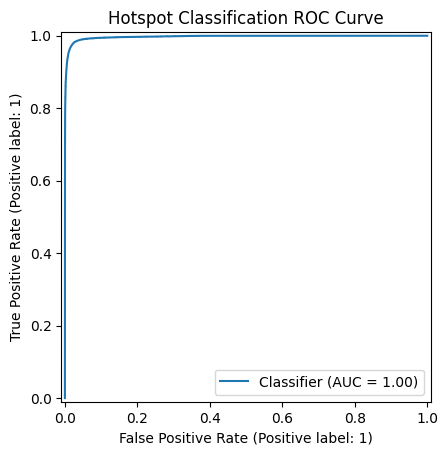

In [28]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("Hotspot Classification ROC Curve")
plt.show()

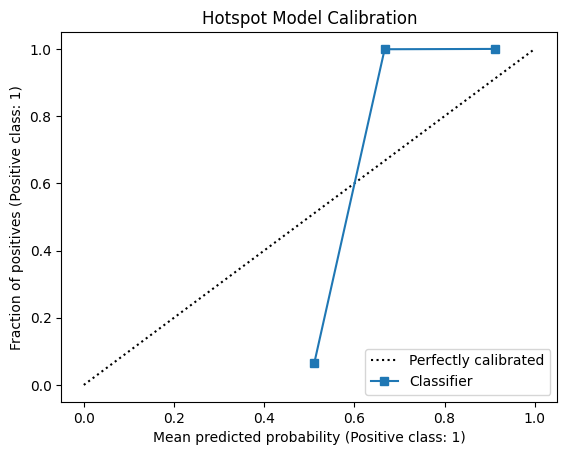

In [29]:
from sklearn.calibration import CalibrationDisplay

CalibrationDisplay.from_predictions(y_test, y_prob)
plt.title("Hotspot Model Calibration")
plt.show()

In [30]:
risk_df = ml_df.iloc[X_test.index].copy()
risk_df["hotspot_probability"] = y_prob

risk_df.sort_values(
    "hotspot_probability", ascending=False
)[["ori", "year", "month", "hotspot_probability"]].head(10)

,ori,year,month,hotspot_probability
953669,TXHPD0000,2022,9,1.0
953633,TXHPD0000,2019,9,1.0
953668,TXHPD0000,2022,8,1.0
953667,TXHPD0000,2022,7,1.0
953666,TXHPD0000,2022,6,1.0
953670,TXHPD0000,2022,10,1.0
953638,TXHPD0000,2020,2,1.0
953679,TXHPD0000,2023,7,1.0
953634,TXHPD0000,2019,10,1.0
953665,TXHPD0000,2022,5,1.0


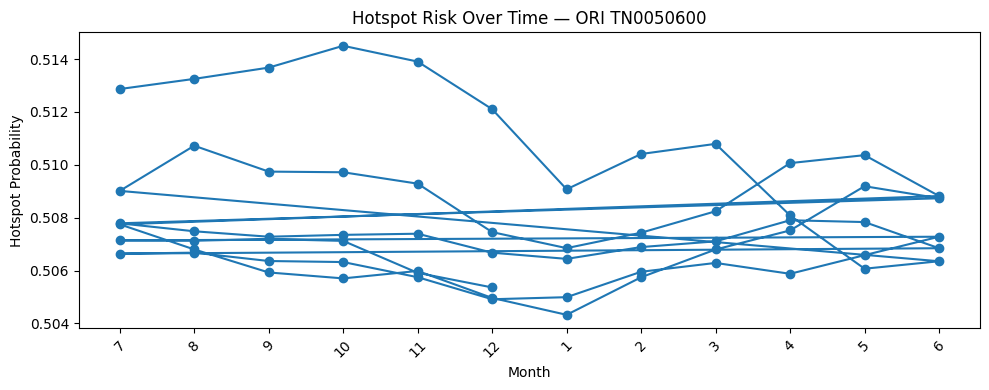

In [31]:

example_ori = risk_df["ori"].iloc[0]
plot_df = risk_df[risk_df["ori"] == example_ori]

plt.figure(figsize=(10, 4))
plt.plot(
    plot_df["month"].astype(str),
    plot_df["hotspot_probability"],
    marker="o"
)
plt.xticks(rotation=45)
plt.title(f"Hotspot Risk Over Time — ORI {example_ori}")
plt.xlabel("Month")
plt.ylabel("Hotspot Probability")
plt.tight_layout()
plt.show()